# Imports

In [1]:
from orbit_generation.visualize import visualize_static_orbits, plot_mean_distance_by_group_column
from orbit_generation.constants import EM_MU
from orbit_generation.stats import calculate_per_orbit_spatial_statistics
from orbit_generation.processing import reorder_orbits, interpolate_equal_times, downsample_3d_array
from orbit_generation.experiment import read_json_to_dataframe, concatenate_csvs_from_experiment_folder, concatenate_and_check_orbits_from_experiment_folder
from orbit_generation.evaluation import calculate_pairwise_distances, calculate_pairwise_orbit_distances
from orbit_generation.dataset import get_first_period_dataset
from orbit_generation.evaluation import evaluate_distance_metrics_and_clustering, machine_learning_evaluation
from orbit_generation.data import TSFeatureWiseScaler
from orbit_generation.dataset import get_first_period_dataset
from orbit_generation.stats import calculate_per_orbit_spatial_statistics

import torch
import pickle
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)


# Data

## Import

In [2]:
data_path = r"/orbit-generation/data/orbits_fix_1500/EM_N_fix_1500.h5"
experiments_folder = r'../../experiments'
experiments_file = r'../../experiments/experiments.json'

In [3]:
df=read_json_to_dataframe(experiments_file)
df.shape

(184, 31)

In [4]:
refined_orbits, refined_orbits_df = concatenate_and_check_orbits_from_experiment_folder(experiments_folder)
refined_orbits_df.head()

,id,old_period,period,iterations_convergence,error,initial_pos_x0,initial_pos_y0,initial_pos_z0,initial_vel_x0,initial_vel_y0,initial_vel_z0,final_pos_x0,final_pos_y0,final_pos_z0,final_vel_x0,final_vel_y0,final_vel_z0,disorder_metric,correct_order,inversions,kendall_tau_distance,propagated_position_error,propagated_velocity_error,propagated_energy_error,latent_distance_to_generation,calculated_jacobi,period_distance_with_generation,feature_closest_orbit,feature_distance_from_closest_orbit,nearest_orbit,nearest_orbit_distance,distance_from_generation,centroid_distance,feature_centroid_distance,closest_family_centroid,closest_family_centroid_distance,closest_family_feature_centroid,closest_family_feature_centroid_distance,initial_conditions_distance,closest_family_full_centroid,closest_family_full_centroid_distance,family_of_feature_closest_orbit,family_of_closest_orbit,experiment_id
0,0,2.825363,3.395283,9,2.866915e-13,1.085847,0.005968,-0.006422,0.007797,0.193831,-0.008355,1.131194,-0.024008,2.689891e-16,-0.007002,0.117360,-2.899136e-15,372.0,66.0,255.0,0.103030,1.329037e-12,2.465352e-12,1.481195e-14,0.116331,3.173176,0.569921,17972,0.000104,17976,0.409855,1.208203,0.830977,3.933960,22,0.166260,6,0.645355,0.095566,6,0.121419,15.0,15.0,54
1,3,6.410875,6.306637,9,3.831047e-10,1.077167,0.244604,0.427690,0.050803,-1.548356,0.846692,0.774984,0.387647,4.910636e-01,0.073323,-1.206546,8.439762e-01,150.0,69.0,98.0,0.039596,6.852558e-12,1.434101e-11,2.466171e-11,0.239348,0.591147,0.104238,30631,0.000694,27453,3.967637,4.725327,2.500625,2.045136,18,0.486709,15,0.159043,0.482846,23,0.482840,29.0,25.0,54
2,5,2.774760,3.382448,8,1.560247e-13,1.078207,0.011581,0.003735,0.007048,0.144430,-0.018307,1.140318,-0.014000,-7.494117e-14,-0.005923,0.077325,1.243685e-13,276.0,64.0,187.0,0.075556,1.162738e-12,2.025713e-12,3.925031e-15,0.140431,3.179420,0.607688,17992,0.000240,17992,0.169285,1.082909,0.824064,3.947770,22,0.173278,6,0.659336,0.097635,6,0.114895,15.0,15.0,54
3,11,22.927443,22.944445,9,6.897051e-12,1.048586,0.020412,-0.036356,0.013088,0.715763,-0.018567,0.906908,0.048871,-1.470502e-02,0.185644,0.562421,2.131846e-02,4.0,98.0,2.0,0.000808,7.630890e-12,1.316706e-11,2.564077e-12,0.045951,2.885993,0.017003,42943,0.003184,42922,2.087514,2.232660,1.988188,15.698535,32,0.302875,37,1.264695,0.276101,37,0.300966,40.0,40.0,54
4,14,6.659652,5.645048,6,3.873477e-12,0.787035,-0.122416,0.049502,0.276159,0.940814,-0.412493,0.642761,-0.185012,1.920668e-02,0.314235,0.605758,-3.829873e-01,68.0,78.0,36.0,0.014545,1.742954e-12,3.321685e-12,1.132078e-12,0.263792,2.810963,1.014603,28414,0.000941,28420,0.970354,2.066139,0.323756,1.658958,19,0.222946,14,0.327624,0.374478,24,0.221195,26.0,26.0,54


In [5]:
print(refined_orbits_df.shape)
print(refined_orbits.shape)

(15419, 44)
(15419, 7, 100)


In [6]:
generation, generation_df = concatenate_and_check_orbits_from_experiment_folder(experiments_folder, csv_file_name='_generation_df.csv', np_file_name='_generated_orbits')
generation_df.head()

,position_error,velocity_error,energy_error,disorder_metric,correct_order,inversions,kendall_tau_distance,nearest_orbit,nearest_orbit_distance,experiment_id
0,0.015872,0.065850,0.090494,110.0,66.0,62.0,0.025101,18000,1.058373,54
1,0.028149,0.046829,0.055805,144.0,67.0,84.0,0.034043,11626,2.858209,54
2,0.088998,0.473862,12.281460,98.0,67.0,55.0,0.022267,3569,6.864561,54
3,0.378554,0.698021,0.593258,266.0,63.0,165.0,0.067611,27418,2.618042,54
4,0.017083,0.056371,0.079053,128.0,65.0,74.0,0.029960,18019,1.074728,54


In [7]:
print(generation_df.shape)
print(generation.shape)

(42000, 10)
(42000, 7, 100)


## Prepare

In [8]:
data, orbit_df, labels, system_dict = get_first_period_dataset(file_path=data_path, segment_length=100)
scaler = TSFeatureWiseScaler()        
scaled_data = scaler.fit_transform(torch.tensor(data, dtype=torch.float32))
scaled_data=scaled_data.numpy()
scaled_data = scaled_data[:,1:,:]
scaled_data.shape

(45211, 6, 100)

In [ ]:
scaled_refined_orbits = scaler.transform(torch.tensor(refined_orbits, dtype=torch.float32))
scaled_refined_orbits = scaled_refined_orbits.numpy()
scaled_refined_orbits = scaled_refined_orbits[:,1:,:]
scaled_refined_orbits.shape 

(15419, 6, 100)

In [10]:
position_stats = calculate_per_orbit_spatial_statistics(scaled_refined_orbits)
position_stats = position_stats.reshape(position_stats.shape[0], -1)
position_stats.shape

(15419, 36)

In [11]:
feature_names = ['period', 'calculated_jacobi']
features = refined_orbits_df[feature_names].values
features.shape

(15419, 2)

In [12]:
# concatenate features and position stats
features_pos_stats = np.concatenate([features, position_stats], axis=1)
features_pos_stats.shape

(15419, 38)

In [13]:
experiment_dict = df.set_index('id_experiment')['discarded_family_ids'].to_dict()
refined_orbits_df['experiment_id'] = refined_orbits_df['experiment_id'].astype(int)
refined_orbits_df['discarded_family_ids'] = refined_orbits_df['experiment_id'].map(experiment_dict)

# Model

In [14]:
with open("02_family_classification_modl.pkl", "rb") as f:
    model = pickle.load(f)

In [15]:
predictions = model.predict(features_pos_stats)
predictions.shape

(15419,)

In [16]:
predictions.shape

(15419,)

# Analysis

In [ ]:
refined_orbits_df['ml_family_classification'] = predictions
refined_orbits_df.head()

,id,old_period,period,iterations_convergence,error,initial_pos_x0,initial_pos_y0,initial_pos_z0,initial_vel_x0,initial_vel_y0,initial_vel_z0,final_pos_x0,final_pos_y0,final_pos_z0,final_vel_x0,final_vel_y0,final_vel_z0,disorder_metric,correct_order,inversions,kendall_tau_distance,propagated_position_error,propagated_velocity_error,propagated_energy_error,latent_distance_to_generation,calculated_jacobi,period_distance_with_generation,feature_closest_orbit,feature_distance_from_closest_orbit,nearest_orbit,nearest_orbit_distance,distance_from_generation,centroid_distance,feature_centroid_distance,closest_family_centroid,closest_family_centroid_distance,closest_family_feature_centroid,closest_family_feature_centroid_distance,initial_conditions_distance,closest_family_full_centroid,closest_family_full_centroid_distance,family_of_feature_closest_orbit,family_of_closest_orbit,experiment_id,discarded_family_ids,ml_family_classification
0,0,2.825363,3.395283,9,2.866915e-13,1.085847,0.005968,-0.006422,0.007797,0.193831,-0.008355,1.131194,-0.024008,2.689891e-16,-0.007002,0.117360,-2.899136e-15,372.0,66.0,255.0,0.103030,1.329037e-12,2.465352e-12,1.481195e-14,0.116331,3.173176,0.569921,17972,0.000104,17976,0.409855,1.208203,0.830977,3.933960,22,0.166260,6,0.645355,0.095566,6,0.121419,15.0,15.0,54,"[7.0, 6.0, 10.0, 11.0, 20.0]",30.0
1,3,6.410875,6.306637,9,3.831047e-10,1.077167,0.244604,0.427690,0.050803,-1.548356,0.846692,0.774984,0.387647,4.910636e-01,0.073323,-1.206546,8.439762e-01,150.0,69.0,98.0,0.039596,6.852558e-12,1.434101e-11,2.466171e-11,0.239348,0.591147,0.104238,30631,0.000694,27453,3.967637,4.725327,2.500625,2.045136,18,0.486709,15,0.159043,0.482846,23,0.482840,29.0,25.0,54,"[7.0, 6.0, 10.0, 11.0, 20.0]",25.0
2,5,2.774760,3.382448,8,1.560247e-13,1.078207,0.011581,0.003735,0.007048,0.144430,-0.018307,1.140318,-0.014000,-7.494117e-14,-0.005923,0.077325,1.243685e-13,276.0,64.0,187.0,0.075556,1.162738e-12,2.025713e-12,3.925031e-15,0.140431,3.179420,0.607688,17992,0.000240,17992,0.169285,1.082909,0.824064,3.947770,22,0.173278,6,0.659336,0.097635,6,0.114895,15.0,15.0,54,"[7.0, 6.0, 10.0, 11.0, 20.0]",30.0
3,11,22.927443,22.944445,9,6.897051e-12,1.048586,0.020412,-0.036356,0.013088,0.715763,-0.018567,0.906908,0.048871,-1.470502e-02,0.185644,0.562421,2.131846e-02,4.0,98.0,2.0,0.000808,7.630890e-12,1.316706e-11,2.564077e-12,0.045951,2.885993,0.017003,42943,0.003184,42922,2.087514,2.232660,1.988188,15.698535,32,0.302875,37,1.264695,0.276101,37,0.300966,40.0,40.0,54,"[7.0, 6.0, 10.0, 11.0, 20.0]",40.0
4,14,6.659652,5.645048,6,3.873477e-12,0.787035,-0.122416,0.049502,0.276159,0.940814,-0.412493,0.642761,-0.185012,1.920668e-02,0.314235,0.605758,-3.829873e-01,68.0,78.0,36.0,0.014545,1.742954e-12,3.321685e-12,1.132078e-12,0.263792,2.810963,1.014603,28414,0.000941,28420,0.970354,2.066139,0.323756,1.658958,19,0.222946,14,0.327624,0.374478,24,0.221195,26.0,26.0,54,"[7.0, 6.0, 10.0, 11.0, 20.0]",6.0


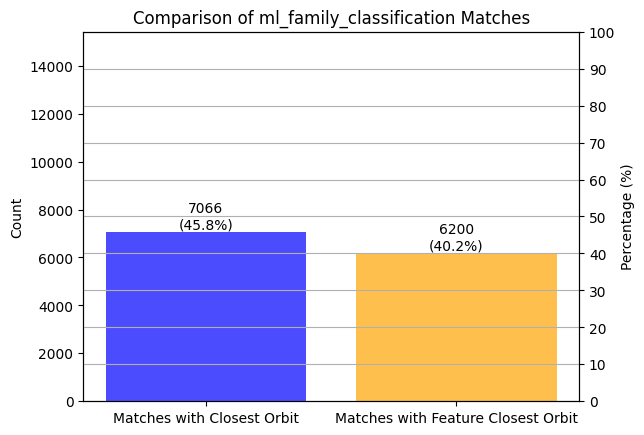

In [ ]:
import matplotlib.pyplot as plt

# Calculate counts
ml_family_counts = refined_orbits_df['ml_family_classification'].value_counts()
family_of_closest_counts = refined_orbits_df['family_of_closest_orbit'].value_counts()
family_of_feature_counts = refined_orbits_df['family_of_feature_closest_orbit'].value_counts()

# Calculate matches
matches_closest = (refined_orbits_df['ml_family_classification'] == refined_orbits_df['family_of_closest_orbit']).sum()
matches_feature = (refined_orbits_df['ml_family_classification'] == refined_orbits_df['family_of_feature_closest_orbit']).sum()

# Calculate percentages
total_count = len(refined_orbits_df)
percent_closest = (matches_closest / total_count) * 100
percent_feature = (matches_feature / total_count) * 100

# Prepare data for plotting
labels = ['Matches with Closest Orbit', 'Matches with Feature Closest Orbit']
counts = [matches_closest, matches_feature]
percentages = [percent_closest, percent_feature]

# Create a bar plot
x = range(len(labels))
fig, ax1 = plt.subplots()

# Bar plot for counts
bars = ax1.bar(x, counts, color=['blue', 'orange'], alpha=0.7, label='Count')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.set_ylabel('Count')
ax1.set_ylim(0, total_count)
ax1.set_title('Comparison of ml_family_classification Matches')

# Add count and percentage on top of the bars
for bar, count, percent in zip(bars, counts, percentages):
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval, f'{count}\n({percent:.1f}%)', ha='center', va='bottom')

# Create a second y-axis for percentages
ax2 = ax1.twinx()
ax2.set_ylim(0, 100)  # Set y-axis limit for percentage
ax2.set_ylabel('Percentage (%)')

# Adjust the ticks on the second y-axis to match the percentage scale
ax2.set_yticks(range(0, 101, 10))

plt.grid(axis='y')
plt.show()


In [19]:
refined_orbits_df.shape

(15419, 46)

In [20]:
refined_orbits_df['is_ml_discovered'] = refined_orbits_df.apply(
    lambda row: row['ml_family_classification'] in row['discarded_family_ids'], axis=1
)

In [21]:
discovery_df = refined_orbits_df[refined_orbits_df['is_ml_discovered'] == True]
discovery_df.shape

(3103, 47)

In [22]:
discovery_df['ml_family_classification'].value_counts()

ml_family_classification
6.0     591
30.0    549
12.0    373
25.0    224
29.0    220
7.0     145
3.0     122
13.0    118
11.0    109
42.0     83
20.0     81
32.0     66
14.0     61
22.0     59
21.0     50
39.0     47
26.0     38
2.0      35
8.0      30
10.0     16
31.0     16
1.0      12
15.0     11
5.0       9
34.0      8
28.0      7
33.0      7
38.0      3
37.0      3
40.0      2
4.0       2
24.0      2
36.0      2
17.0      1
16.0      1
Name: count, dtype: int64